In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


## main run of experiments

In [ ]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:8]  # Select experiments
    
with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
experiment_names

['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem',
 '07_aux_task']

In [3]:
import random

global_config = md.global_config
# reproducible shuffling (num_workers=0 -> simpler)
startseed = global_config['seed']
run_id_base = "251102_ALLIN"
repetitions = [0, 1, 2, 3, 4]


for i in repetitions: # Run 10 experiments with different seeds
    #run_id = md.generate_run_id()
    run_id = run_id_base + f"_{i}"
    seed = startseed + i  # Different seed for each experiment
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    for exp_name in experiment_names:
        
        sites, cfg = cf.get_config(exp_name)  
        cfg.update(global_config)  # Ensure cfg has the latest global_config
        cfg.update({"seed": seed})
        #print("=== NEW EXPERIMENT ===")
        print(f" NEW: --> Name: {exp_name}, Run ID: {run_id}, Seed: {seed}")

        # Build dataset
        X, Y, site_indices = dt.build_patched_dataset(cfg, sites, patch_size=32, nan_percent_allowed=20)
        
        # split into train/val/test (70/15/15) with your logic
        (X_train, Y_train), (X_val, Y_val), (X_test, Y_test), site_indices_test = dt.split_dataset(X, Y, seed=seed, site_indices=site_indices)

        # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
        train_dataset = md.S2CanopyHeightDataset(X_train, Y_train, cfg)
        val_dataset = md.S2CanopyHeightDataset(X_val, Y_val, cfg)
        test_dataset = md.S2CanopyHeightDataset(X_test, Y_test, cfg)

        train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'],shuffle=True,num_workers=0)
        val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
        test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
        
        if False:
            print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
            print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
            print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")
        
        # build model depending on in out channels, defined by the dataloaders
        model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0],cfg=cfg)
         
        #train model depending on config. 
        model, logs = md.train_model(model, train_loader, val_loader, cfg)

        md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=run_id, site_indices_test=site_indices_test)

        #eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
        #print("Minimum Validation Loss: ", min(logs['val_loss']))
        #print("DONE WITH ", exp_name)
        #print("=================")
    print("DONE WITH ALL EXPERIMENTS for iteration ", i)

 NEW: --> Name: 01_baseline, Run ID: 251102_ALLIN_0, Seed: 50


Epochs:  87%|████████▋ | 433/500 [05:41<00:52,  1.27it/s]

Early stopping triggered at epoch 434


Results saved to: ../results/251102_ALLIN_0/train/01_baseline
 NEW: --> Name: 02_pixel_composites, Run ID: 251102_ALLIN_0, Seed: 50


Epochs: 100%|██████████| 500/500 [07:25<00:00,  1.12it/s]


Results saved to: ../results/251102_ALLIN_0/train/02_pixel_composites
 NEW: --> Name: 03_seasonal_composites, Run ID: 251102_ALLIN_0, Seed: 50


Epochs:  88%|████████▊ | 438/500 [05:17<00:44,  1.38it/s]

Early stopping triggered at epoch 439


Results saved to: ../results/251102_ALLIN_0/train/03_seasonal_composites
 NEW: --> Name: 04_pixel_and_seasonal_comp, Run ID: 251102_ALLIN_0, Seed: 50


Epochs: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Results saved to: ../results/251102_ALLIN_0/train/04_pixel_and_seasonal_comp
 NEW: --> Name: 05_support_fmask_dlt, Run ID: 251102_ALLIN_0, Seed: 50


Epochs:  98%|█████████▊| 492/500 [06:34<00:06,  1.25it/s]

Early stopping triggered at epoch 493


Results saved to: ../results/251102_ALLIN_0/train/05_support_fmask_dlt
 NEW: --> Name: 06_support_fmask_dlt_dem, Run ID: 251102_ALLIN_0, Seed: 50


Epochs: 100%|██████████| 500/500 [06:45<00:00,  1.23it/s]


Results saved to: ../results/251102_ALLIN_0/train/06_support_fmask_dlt_dem
 NEW: --> Name: 07_aux_task, Run ID: 251102_ALLIN_0, Seed: 50


Epochs: 100%|██████████| 500/500 [09:07<00:00,  1.10s/it]


Results saved to: ../results/251102_ALLIN_0/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  0
 NEW: --> Name: 01_baseline, Run ID: 251102_ALLIN_1, Seed: 51


Epochs:  97%|█████████▋| 483/500 [06:24<00:13,  1.26it/s]

Early stopping triggered at epoch 484


Results saved to: ../results/251102_ALLIN_1/train/01_baseline
 NEW: --> Name: 02_pixel_composites, Run ID: 251102_ALLIN_1, Seed: 51


Epochs: 100%|██████████| 500/500 [07:22<00:00,  1.13it/s]


Results saved to: ../results/251102_ALLIN_1/train/02_pixel_composites
 NEW: --> Name: 03_seasonal_composites, Run ID: 251102_ALLIN_1, Seed: 51


Epochs: 100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


Results saved to: ../results/251102_ALLIN_1/train/03_seasonal_composites
 NEW: --> Name: 04_pixel_and_seasonal_comp, Run ID: 251102_ALLIN_1, Seed: 51


Epochs: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Results saved to: ../results/251102_ALLIN_1/train/04_pixel_and_seasonal_comp
 NEW: --> Name: 05_support_fmask_dlt, Run ID: 251102_ALLIN_1, Seed: 51


Epochs: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Results saved to: ../results/251102_ALLIN_1/train/05_support_fmask_dlt
 NEW: --> Name: 06_support_fmask_dlt_dem, Run ID: 251102_ALLIN_1, Seed: 51


Epochs:  84%|████████▍ | 422/500 [05:40<01:02,  1.24it/s]

Early stopping triggered at epoch 423


Results saved to: ../results/251102_ALLIN_1/train/06_support_fmask_dlt_dem
 NEW: --> Name: 07_aux_task, Run ID: 251102_ALLIN_1, Seed: 51


Epochs: 100%|██████████| 500/500 [09:08<00:00,  1.10s/it]


Results saved to: ../results/251102_ALLIN_1/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  1
 NEW: --> Name: 01_baseline, Run ID: 251102_ALLIN_2, Seed: 52


Epochs: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Results saved to: ../results/251102_ALLIN_2/train/01_baseline
 NEW: --> Name: 02_pixel_composites, Run ID: 251102_ALLIN_2, Seed: 52


Epochs: 100%|██████████| 500/500 [07:22<00:00,  1.13it/s]


Results saved to: ../results/251102_ALLIN_2/train/02_pixel_composites
 NEW: --> Name: 03_seasonal_composites, Run ID: 251102_ALLIN_2, Seed: 52


Epochs:  81%|████████  | 404/500 [04:52<01:09,  1.38it/s]

Early stopping triggered at epoch 405


Results saved to: ../results/251102_ALLIN_2/train/03_seasonal_composites
 NEW: --> Name: 04_pixel_and_seasonal_comp, Run ID: 251102_ALLIN_2, Seed: 52


Epochs:  81%|████████▏ | 407/500 [05:27<01:14,  1.24it/s]

Early stopping triggered at epoch 408


Results saved to: ../results/251102_ALLIN_2/train/04_pixel_and_seasonal_comp
 NEW: --> Name: 05_support_fmask_dlt, Run ID: 251102_ALLIN_2, Seed: 52


Epochs:  69%|██████▉   | 344/500 [04:37<02:05,  1.24it/s]

Early stopping triggered at epoch 345


Results saved to: ../results/251102_ALLIN_2/train/05_support_fmask_dlt
 NEW: --> Name: 06_support_fmask_dlt_dem, Run ID: 251102_ALLIN_2, Seed: 52


Epochs:  92%|█████████▏| 460/500 [06:12<00:32,  1.23it/s]

Early stopping triggered at epoch 461


Results saved to: ../results/251102_ALLIN_2/train/06_support_fmask_dlt_dem
 NEW: --> Name: 07_aux_task, Run ID: 251102_ALLIN_2, Seed: 52


Epochs:  82%|████████▏ | 409/500 [07:29<01:40,  1.10s/it]

Early stopping triggered at epoch 410


Results saved to: ../results/251102_ALLIN_2/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  2
 NEW: --> Name: 01_baseline, Run ID: 251102_ALLIN_3, Seed: 53


Epochs: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Results saved to: ../results/251102_ALLIN_3/train/01_baseline
 NEW: --> Name: 02_pixel_composites, Run ID: 251102_ALLIN_3, Seed: 53


Epochs: 100%|██████████| 500/500 [07:30<00:00,  1.11it/s]


Results saved to: ../results/251102_ALLIN_3/train/02_pixel_composites
 NEW: --> Name: 03_seasonal_composites, Run ID: 251102_ALLIN_3, Seed: 53


Epochs: 100%|██████████| 500/500 [06:02<00:00,  1.38it/s]


Results saved to: ../results/251102_ALLIN_3/train/03_seasonal_composites
 NEW: --> Name: 04_pixel_and_seasonal_comp, Run ID: 251102_ALLIN_3, Seed: 53


Epochs:  97%|█████████▋| 486/500 [06:32<00:11,  1.24it/s]

Early stopping triggered at epoch 487


Results saved to: ../results/251102_ALLIN_3/train/04_pixel_and_seasonal_comp
 NEW: --> Name: 05_support_fmask_dlt, Run ID: 251102_ALLIN_3, Seed: 53


Epochs:  99%|█████████▊| 493/500 [06:36<00:05,  1.24it/s]

Early stopping triggered at epoch 494


Results saved to: ../results/251102_ALLIN_3/train/05_support_fmask_dlt
 NEW: --> Name: 06_support_fmask_dlt_dem, Run ID: 251102_ALLIN_3, Seed: 53


Epochs:  94%|█████████▍| 471/500 [06:21<00:23,  1.23it/s]

Early stopping triggered at epoch 472


Results saved to: ../results/251102_ALLIN_3/train/06_support_fmask_dlt_dem
 NEW: --> Name: 07_aux_task, Run ID: 251102_ALLIN_3, Seed: 53


Epochs:  72%|███████▏  | 362/500 [06:35<02:30,  1.09s/it]

Early stopping triggered at epoch 363


Results saved to: ../results/251102_ALLIN_3/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  3
 NEW: --> Name: 01_baseline, Run ID: 251102_ALLIN_4, Seed: 54


Epochs:  74%|███████▍  | 370/500 [04:43<01:39,  1.30it/s]

Early stopping triggered at epoch 371


Results saved to: ../results/251102_ALLIN_4/train/01_baseline
 NEW: --> Name: 02_pixel_composites, Run ID: 251102_ALLIN_4, Seed: 54


Epochs: 100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


Results saved to: ../results/251102_ALLIN_4/train/02_pixel_composites
 NEW: --> Name: 03_seasonal_composites, Run ID: 251102_ALLIN_4, Seed: 54


Epochs: 100%|██████████| 500/500 [06:03<00:00,  1.37it/s]


Results saved to: ../results/251102_ALLIN_4/train/03_seasonal_composites
 NEW: --> Name: 04_pixel_and_seasonal_comp, Run ID: 251102_ALLIN_4, Seed: 54


Epochs: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Results saved to: ../results/251102_ALLIN_4/train/04_pixel_and_seasonal_comp
 NEW: --> Name: 05_support_fmask_dlt, Run ID: 251102_ALLIN_4, Seed: 54


Epochs:  99%|█████████▉| 495/500 [06:38<00:04,  1.24it/s]

Early stopping triggered at epoch 496


Results saved to: ../results/251102_ALLIN_4/train/05_support_fmask_dlt
 NEW: --> Name: 06_support_fmask_dlt_dem, Run ID: 251102_ALLIN_4, Seed: 54


Epochs: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Results saved to: ../results/251102_ALLIN_4/train/06_support_fmask_dlt_dem
 NEW: --> Name: 07_aux_task, Run ID: 251102_ALLIN_4, Seed: 54


Epochs: 100%|██████████| 500/500 [09:06<00:00,  1.09s/it]


Results saved to: ../results/251102_ALLIN_4/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  4


duration: 7 exp x 5 runs = 35 tasks 
233min = 233/60 = 3h50min 

# Some model stats

In [ ]:
from torchinfo import summary
from torch.nn import Conv2d, MaxPool2d, ConvTranspose2d

num_in = X[0].shape[0]
num_out = Y[0].shape[0]
output_bands = 3
print("Number of input bands: ", num_in)

# Calculate the number of parameters and model depth
model_stats = summary(model, input_size=(1, num_in+1, global_config['patch_size'], global_config['patch_size']), device=global_config['device'])
print(model_stats)



# Function to calculate the receptive field
def calculate_receptive_field(model, input_size):
    """
    Calculate the receptive field of the model.
    """

    receptive_field = 1
    stride = 1
    padding = 0

    for layer in model.modules():
        if isinstance(layer, (Conv2d, MaxPool2d, ConvTranspose2d)):
            kernel_size = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size, layer.kernel_size)
            stride = layer.stride if isinstance(layer.stride, tuple) else (layer.stride, layer.stride)
            padding = layer.padding if isinstance(layer.padding, tuple) else (layer.padding, layer.padding)

            receptive_field = (receptive_field - 1) * stride[0] + kernel_size[0] - 2 * padding[0]

    return receptive_field

# Calculate the receptive field
receptive_field = calculate_receptive_field(model, input_size=(1, global_config['num_bands'], global_config['patch_size'], global_config['patch_size']))
print(f"Receptive Field: {receptive_field}")
# Check if the model uses BatchNorm layers
batchnorm_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.BatchNorm2d)]
if batchnorm_layers:
    print(f"The model uses {len(batchnorm_layers)} BatchNorm2d layers.")
    for i, layer in enumerate(batchnorm_layers, 1):
        print(f"BatchNorm Layer {i}: {layer}")
else:
    print("The model does not use any BatchNorm2d layers.")

    # Check if the model contains 1x1 convolutional layers
    conv1x1_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d) and layer.kernel_size == (1, 1)]
    if conv1x1_layers:
        print(f"The model contains {len(conv1x1_layers)} 1x1 Conv2d layers.")
        for i, layer in enumerate(conv1x1_layers, 1):
            print(f"1x1 Conv2d Layer {i}: {layer}")
    else:
        print("The model does not contain any 1x1 Conv2d layers.")

Number of input bands:  117
Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           68,032
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Dropout2d: 2-3                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-5                         [1, 64, 32, 32]           --
│    └─Dropout2d: 2-6                    [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-7                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-8                         [1, 128, 16, 16]          --
│    └─Dropout2d: 2-9                    [1, 

In [57]:
#do i have mixed or fixed precision training enabled in default mps devide torch? print("Is MPS available: ", torch.backends.mps.is_available())
print("Is MPS built: ", torch.backends.mps.is_built())
print("Current device: ", torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
print("Is automatic mixed precision (AMP) enabled: ", torch.cuda.is_available() and torch.cuda.amp.is_available())

Is MPS built:  True
Current device:  mps
Is automatic mixed precision (AMP) enabled:  False


In [ ]:
pytorch_version = torch.__version__
print("PyTorch version: ", pytorch_version)


PyTorch version:  2.7.0
CUDA is not available on this system.


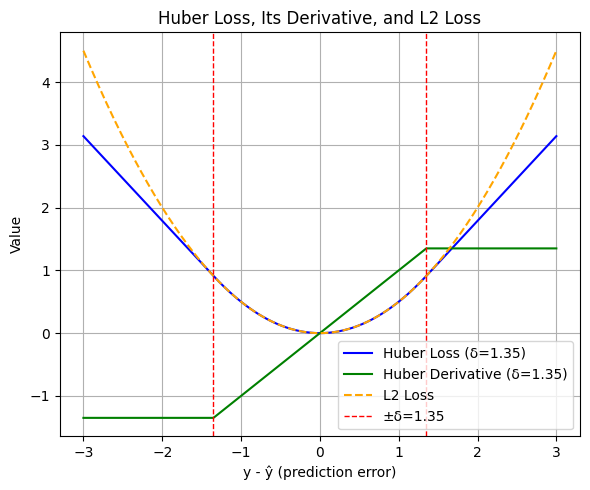

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# Define the Huber loss function
def huber_loss(x, delta):
    return np.where(np.abs(x) <= delta, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))

# Define the derivative of the Huber loss function
def huber_loss_derivative(x, delta):
    return np.where(np.abs(x) <= delta, x, delta * np.sign(x))

# Generate x values
x = np.linspace(-3, 3, 500)

# Calculate Huber loss and its derivative
delta = 1.35
loss = huber_loss(x, delta)
derivative = huber_loss_derivative(x, delta)

# Plot the Huber loss, its derivative, and L2 loss in one plot
fig = plt.figure(figsize=(6, 5))

# Plot Huber loss
plt.plot(x, loss, label=f"Huber Loss (δ={delta})", color="blue")

# Plot Huber loss derivative
#plt.plot(x, loss, label=f"Huber Loss (δ={delta})", color="blue")
plt.plot(x, derivative, label=f"Huber Derivative (δ={delta})", color="green")

# Add L2 loss for reference
l2_loss = 0.5 * x**2
plt.plot(x, l2_loss, label="L2 Loss", color="orange", linestyle="--")

# Add vertical lines for ±δ
plt.axvline(x=-delta, color="red", linestyle="--", linewidth=1, label=f"±δ={delta}")
plt.axvline(x=delta, color="red", linestyle="--", linewidth=1)

# Add title, labels, legend, and grid
plt.title("Huber Loss, Its Derivative, and L2 Loss")
plt.xlabel("y - ŷ (prediction error)")
plt.ylabel("Value")
plt.legend()
plt.grid()

plt.tight_layout()
#plt.show()

# save figure
output_folder = "../images/"
# create folder
os.makedirs(os.path.dirname(output_folder), exist_ok=True)
plt.savefig(f"{output_folder}06_LossFunctions.pdf", dpi=300)
